In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split 
from sklearn import metrics

# Load the Data

In [3]:
messages = pd.read_csv('spam.csv',encoding = 'latin-1')
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
messages.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [5]:
### Remove the unnecessary columns for dataset and rename the column names.

In [6]:
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "message"]

In [7]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [12]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [13]:
# Count the frequency of top 5 messages.
messages['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
4,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4


## Data Visualization

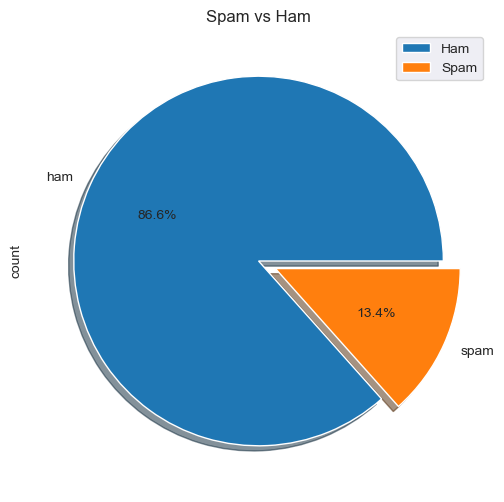

In [15]:
messages["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Text(0, 0.5, 'Frequency')

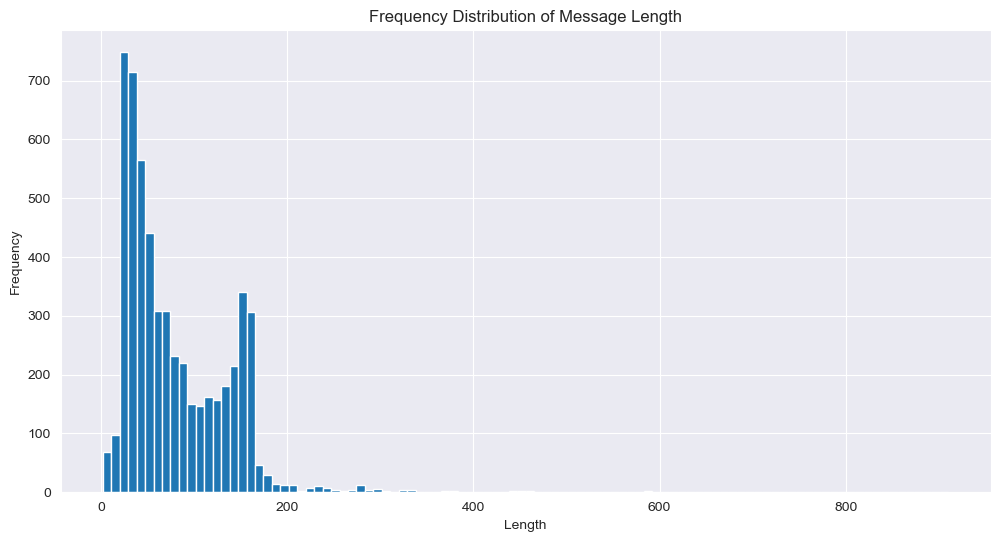

In [16]:
plt.figure(figsize=(12,6))
messages['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

In [17]:
messages['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [18]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

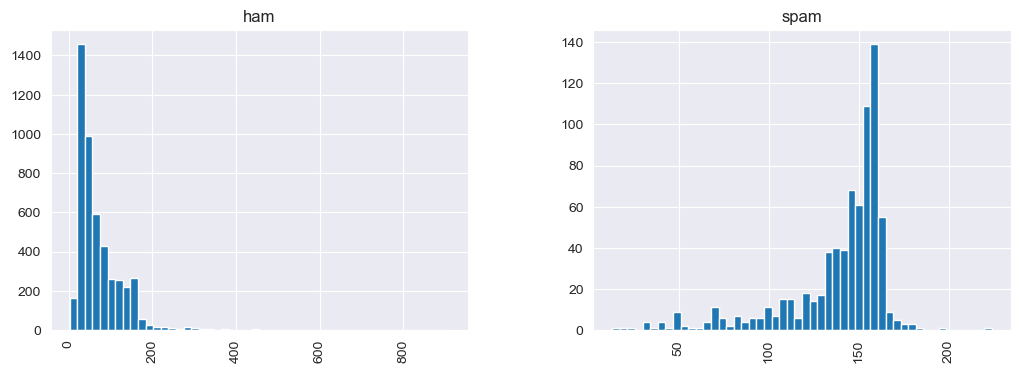

In [19]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4)) 

# Text Pre-processing

In [21]:
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    return nostop

In [22]:
spam_messages = messages[messages["label"] == "spam"]["message"]
ham_messages = messages[messages["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  747
No of ham messages :  4825


In [23]:
# This may take a while....
spam_words = text_preprocess(spam_messages )

In [24]:
# lets print some spam words
spam_words[:10]

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may']

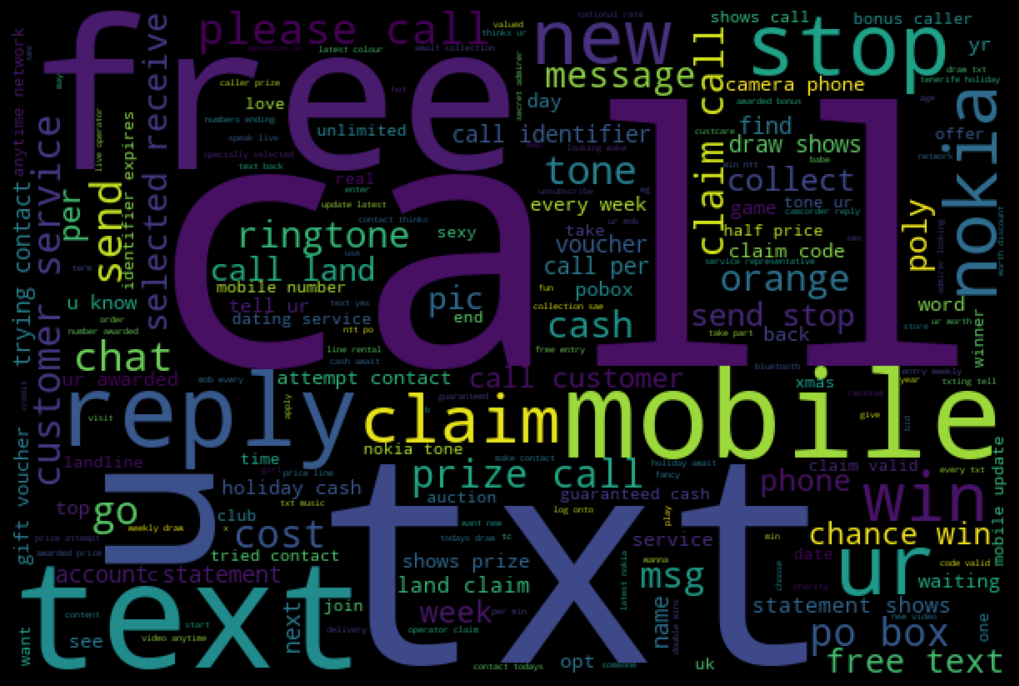

In [25]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [26]:
print("Top 10 Spam words are :\n")
print(pd.Series(spam_words).value_counts().head(10))

Top 10 Spam words are :

call      331
free      146
txt       136
ur        129
mobile    108
text      107
claim     105
u          98
reply      98
stop       78
Name: count, dtype: int64


In [27]:
# This may take a while...
ham_words = text_preprocess(ham_messages)

In [28]:
# lets pring some ham words
ham_words[:10]

['go',
 'jurong',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'cine']

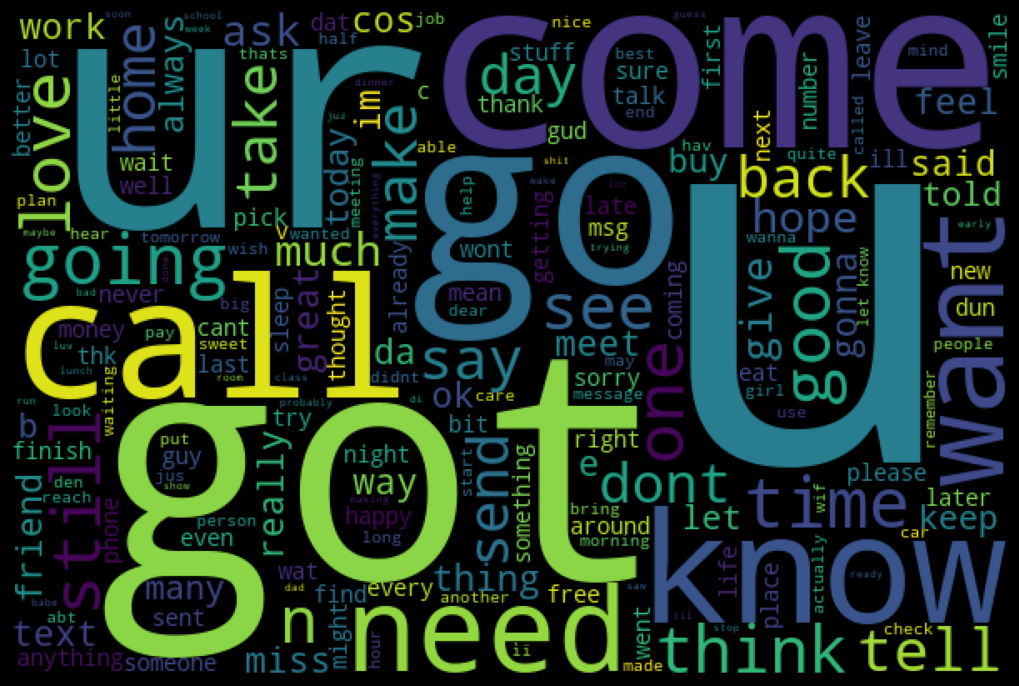

In [29]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [30]:
print("Top 10 Ham words are :\n")
print(pd.Series(ham_words).value_counts().head(10))

Top 10 Ham words are :

u        820
get      287
ur       235
go       231
got      216
like     215
know     202
come     201
call     200
going    151
Name: count, dtype: int64


# Data Transformation

In [32]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [33]:
# This might take a while....

# Lets remove punctuations/ stopwords from all SMS 
messages["message"] = messages["message"].apply(text_preprocess)

In [34]:
# Conver the SMS into string from list
messages["message"] = messages["message"].agg(lambda x: ' '.join(map(str, x)))

In [35]:
messages.head()

,label,message,length
0,ham,go jurong point crazy available bugis n great ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry wkly comp win fa cup final tkts may...,155
3,ham,u dun say early hor u c already say,49
4,ham,nah dont think goes usf lives around though,61


In [36]:
messages["message"][7]

'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune'

# Continuing Normalization


In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(messages['message'])

print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names_out()[20:40])

print("\nTotal number of vocab words : ", len(vectorizer.vocabulary_))


20 Bag of Words (BOW) Features: 

['absence' 'absolutely' 'abstract' 'abt' 'abta' 'aburo' 'abuse' 'abusers'
 'ac' 'academic' 'acc' 'accent' 'accenture' 'accept' 'access' 'accessible'
 'accidant' 'accident' 'accidentally' 'accommodation']

Total number of vocab words :  8084


In [40]:
message4 = messages['message'][3]
print(message4)

u dun say early hor u c already say


In [41]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 207)	1
  (0, 1981)	1
  (0, 2000)	1
  (0, 3141)	1
  (0, 5945)	2
(1, 8084)


In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(messages['message'])

feature_names = vectorizer.get_feature_names_out()
print(feature_names[5945])


say


In [44]:
messages_bow = bow_transformer.transform(messages['message'])

In [45]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 8084)
Amount of Non-Zero occurences:  44211


### TF-IDF

In [77]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

bow_transformer = vectorizer.fit_transform(messages['message'])

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(bow_transformer)

tfidf4 = tfidf_transformer.transform(bow4)

print(tfidf4)


  (0, 5945)	0.6206136295983186
  (0, 3141)	0.5139528069861297
  (0, 2000)	0.37127907512470754
  (0, 1981)	0.3420160440299522
  (0, 207)	0.3096257562744466


In [78]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit_transform(messages['message'])

# Get the feature names from the fitted CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Now you can access specific features by index
print(feature_names[5945])
print(feature_names[3141])


say
hor


In [57]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Assuming bow_transformer is your Bag of Words representation
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit_transform(messages['message'])

# Create and fit the TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(bow_transformer)

# Access idf_ directly from the TfidfTransformer
idf_of_say = tfidf_transformer.idf_[vectorizer.vocabulary_['say']]

print(idf_of_say)


5.14835197309133


### To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [59]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 8084)


In [60]:
messages["message"][:10]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts may...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
5    freemsg hey darling weeks word back id like fu...
6       even brother like speak treat like aids patent
7    per request melle melle oru minnaminunginte nu...
8    winner valued network customer selected receiv...
9    mobile months u r entitled update latest colou...
Name: message, dtype: object

### Lets convert our clean text into a representation that a machine learning model can understand. I'll use the Tfifd for this.

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["message"])
print(features.shape) 

print(len(vec.vocabulary_))

(5572, 7927)
7927


# Model Evaluation

In [64]:
msg_train, msg_test, label_train, label_test = \
train_test_split(messages_tfidf, messages['label'], test_size=0.2)

In [65]:
print("train dataset features size : ",msg_train.shape)
print("train dataset label size", label_train.shape)

print("\n")

print("test dataset features size", msg_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (4457, 8084)
train dataset label size (4457,)


test dataset features size (1115, 8084)
test dataset lable size (1115,)


## Building Naive Bayes classifier Model

In [67]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
spam_detect_model = clf.fit(msg_train, label_train)

In [68]:
predict_train = spam_detect_model.predict(msg_train)

In [69]:
print("Classification Report \n",metrics.classification_report(label_train, predict_train))
print("\n")
print("Confusion Matrix \n",metrics.confusion_matrix(label_train, predict_train))
print("\n")
print("Accuracy of Train dataset : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train)))

Classification Report 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3861
        spam       1.00      0.81      0.90       596

    accuracy                           0.98      4457
   macro avg       0.99      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457



Confusion Matrix 
 [[3861    0]
 [ 111  485]]


Accuracy of Train dataset : 0.975


In [70]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages['label'][3])

predicted: ham
expected: ham


## Model Evaluation


In [74]:
label_predictions = spam_detect_model.predict(msg_test)
print(label_predictions)

print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

['ham' 'ham' 'ham' ... 'spam' 'ham' 'ham']
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       964
        spam       1.00      0.71      0.83       151

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

[[964   0]
 [ 44 107]]


In [75]:
# Printing the Overall Accuracy of the model
print("Accuracy of the model : {0:0.3f}".format(metrics.accuracy_score(label_test, label_predictions)))

Accuracy of the model : 0.961
